# Spanish Sentiment Analysis of tweets from Telecomm Industry 

In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re

#nltk.download('stopwords')
#nltk.download('wordnet')
stopwords = stopwords.words('spanish')
stopwords.remove('no')

In [2]:
df = pd.read_excel(r'sentiment_data\train_tweets.xlsx', usecols=[' desc', ' sentiment'])
df.head()

,desc,sentiment
0,鉁?Famous Followers 馃 @CableFibertel 馃 @guiy...,0
1,@JavierSassi @CableFibertel Son de lo peor,-1
2,RT @JavierSassi: Uno paga al dia x este p茅sim...,-1
3,@kevinkevre @CableFibertel @BAconsumidor Telec...,-1
4,@JavierSassi @CableFibertel Pasate a @ClaroArg...,-1


In [3]:
# initalizing the werdnet lemmatizer
lm = WordNetLemmatizer()
# creating a new column to store rows after processing
df['post_processed'] = ''
# iterating over all rows one by one

stopwords.extend(['rt'])
def processing(curr_tweet):

#     curr_tweet = data.iloc[i,0]
    curr_tweet = curr_tweet.split(' ')
#     removing stopwords
    curr_tweet = [word.strip().lower() for word in curr_tweet if word.lower() not in stopwords]
#     removing these punctuations from tokens like it will convert the word mode? into mode
    rx = re.compile('([&#.:?!-()])*')
    curr_tweet = [rx.sub('', word) for word in curr_tweet]
    
    curr_tweet = [word for word in curr_tweet if len(word)>1 and word.isalpha()]
#   stemming the words  
    curr_tweet = [lm.lemmatize(word) for word in curr_tweet]
    
#     print(curr_tweet)

    return ' '.join(curr_tweet)

for i in range(len(df)):
    df.iloc[i,2] = processing(df.iloc[i,0])

In [4]:
# removing chineese characters
df['post_processed'] = df['post_processed'].str.replace(r'[^\x00-\x7F]+', '').str.strip()

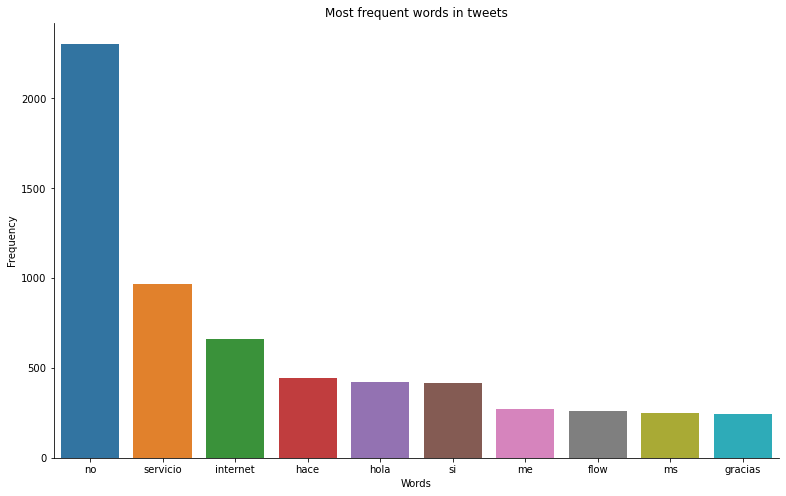

In [5]:
tokens = [word for sentence in df['post_processed'] for word in sentence.split(' ') if len(word)>1]
frequency = nltk.FreqDist(tokens)
freq_data = pd.DataFrame({'Words': list(frequency.keys()),
                  'Count': list(frequency.values())})

plt.figure(figsize=(13,8))
sns.barplot(data=freq_data.nlargest(columns='Count', n=10), x='Words', y='Count')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Most frequent words in tweets')
plt.xlabel('Words')
plt.savefig('frequencies.png')
plt.ylabel('Frequency')
plt.show()

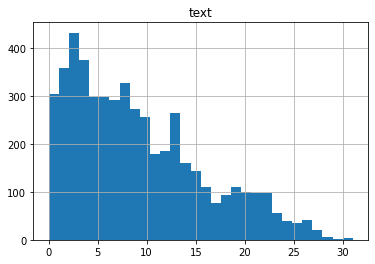

In [6]:
#nltk.download('punkt')
text_lengths = []
for i in range(len(df)):
    curr_text = df.iloc[i,2]
    text_lengths.append(len([word for sent in sent_tokenize(curr_text) for word in word_tokenize(sent)]))
    # summary_lengths.append(len([word for sent in sent_tokenize(curr_summary) for word in word_tokenize(sent)]))
    

length_df = pd.DataFrame({'text':text_lengths })
length_df.hist(bins = 30)
plt.show()

<h4>Word Embeddings </h4>

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(df['post_processed'])
vocab = tfidf.vocabulary_
# len(vocab)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, df[' sentiment'] )

<h4>Grid Search CV</h4>

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc=SVC(random_state=0)
parameters = {'kernel' :[ 'linear', 'poly', 'rbf', 'sigmoid'],
               'gamma' : ['scale', 'auto'],
              'C':[0.001,0.1,1.0, 2.0, 3.0] }

clf = GridSearchCV(svc, parameters, scoring='f1_weighted', cv=10)
clf.fit(x_train, y_train)

print('Parameters that have shown best results are: ', clf.best_params_)
print('\nBest score is: ', clf.best_score_)

svc = SVC(random_state=0,**clf.best_params_)
svc.fit(x_train, y_train)

# predictions = svc.predict(x_test)
# print( classification_report(y_test, predictions) )

Parameters that have shown best results are:  {'C': 2.0, 'gamma': 'scale', 'kernel': 'linear'}

Best score is:  0.8181296186396763


SVC(C=2.0, kernel='linear', random_state=0)

<h4>Training Results</h4>

In [10]:
from sklearn.metrics import classification_report
predictions = svc.predict( x_train )
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

          -1       0.94      0.96      0.95      2529
           0       0.90      0.87      0.88      1193
           1       1.00      0.73      0.85        56

    accuracy                           0.93      3778
   macro avg       0.95      0.85      0.89      3778
weighted avg       0.93      0.93      0.93      3778



In [11]:
predictions = svc.predict( x_test )
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.84      0.87      0.85       816
           0       0.72      0.70      0.71       420
           1       1.00      0.46      0.63        24

    accuracy                           0.80      1260
   macro avg       0.85      0.67      0.73      1260
weighted avg       0.80      0.80      0.80      1260



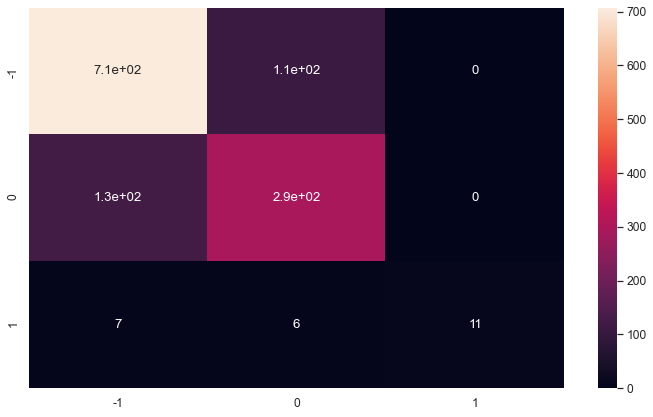

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

names = ['-1','0', '1']
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), names, names)

plt.figure(figsize=(12, 7) )
sns.set(font_scale=1.1) # for label size
sns.heatmap(df_cm, annot=True)

In [13]:
import pickle
filename = r'models\finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))

# load the model from disk
saved_model = pickle.load(open(filename, 'rb'))

### Applied Model on Tweets

In [28]:
pred_df = pd.read_excel(r'C:\Users\o84178899\huawei_dev\social_listening\retriever\twitter_data\argentina\enero_2021\cablefibertel_argentina_01-2021.xlsx')
pred_df['post_processing'] = ''
pred_df['text'] = pred_df['tweet']
pred_df = pred_df[['name','text']]
pred_df
processed= []
for i in range(len(pred_df)):
    processed.append( processing(pred_df.iloc[i,1]) )

In [29]:
processed

['continuar brindando prestación calidad',
 'podrian devolverme ma aumentaron razón',
 'no da servicio pésimo ensimacablevisionteroba',
 'devuelven decreto sacado dicen empresa no apruebe no devuelven alto chorros',
 'sigue cortando cable porquería servicio estafa cotidiana',
 'ah so re troll',
 'basta robarnos',
 'boleta vino importe no puede pagar',
 'tremendos ladrones',
 'posta malos solución siempre anda mal no hacen',
 'sigo esperando solucionen problema loco cómo encanta hacerse pelotudos responder',
 'anda quejarte cantando',
 'harta cansada tener mendigando respuestas respondan falla técnicos mientras adornan te regalamos gigas personal do días internet ahora cable',
 'da mucha bronca situación creo tenés suerte toque alguien decente ayude alguien ponga obstáculos chau da mucha impotencia',
 '',
 'señal cable hace hora ademas enero febrero incrementaron no correspondia hagan ambas cosas',
 'caes pedazos concha madre',
 'volvi casa después días no wifi dejate romper pelota vos 

In [30]:
tfidf_matrix = tfidf.transform(processed)
predictions=saved_model.predict(tfidf_matrix)
pred_df['Predictions'] = predictions
pred_df.to_excel(r'C:\Users\o84178899\huawei_dev\social_listening\sentiment\sentiment_results\sentiment_cablefibertel_argentina_01-2021.xlsx',index=True)